TODO

In [1]:
import os
import sys

os.chdir('..')

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.Descriptors import qed, MolWt
from rdkit.Chem.Draw import MolsToGridImage

from src.tacogfn.utils import sascore
from src.tacogfn.eval import docking
from src.tacogfn.utils import molecules

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.tacogfn.tasks import pharmaco_frag

In [43]:
model_state = torch.load('logs/2024-01-17-alpha-default/model_state_25000.pt')

In [49]:
config = dict(model_state['cfg'])
config['avg_prediction_for_pocket_path'] = "model_weights/avg_scores/avg_for_base_100_per_pocket.pt"

In [74]:
trail = pharmaco_frag.PharmacophoreTrainer(config)
trail.model.load_state_dict(model_state['models_state_dict'][0])
trail.model.eval()

loaded 15016 ids for train
loaded 100 ids for test


Hyperparameters:

log_dir: ./logs/2024_01_16_run_pharmaco_frag_alpha
logger: wandb
device: cuda
split_file: dataset/split_by_name.pt
pharmacophore_db_path: misc/pharmacophores_db.lmdb
affinity_predictor_path: model_weights/base_100_per_pocket.pth
avg_prediction_for_pocket_path: model_weights/avg_scores/avg_for_base_100_per_pocket.pt
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 50000
num_workers: 8
hostname: 1b47fa7fe7d3
pickle_mp_messages: false
git_hash: 2dff1d3
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 64
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logreward: -75.0
  offline_ratio: 0.0
  valid_offline_ratio: 0.0
  train_random_action_prob: 0.01
  valid_random_action_prob: 0.0
  valid_sample_cond_info: true
  sampling_tau: 0.99
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_mu

PharmacophoreConditionalGraphTransformerGFN(
  (transf): PharmacophoreConditionalGraphTransformer(
    (pharmacophore_encoder): GVP_embedding(
      (W_s): Embedding(10, 10)
      (W_v): Sequential(
        (0): LayerNorm(
          (scalar_norm): LayerNorm((34,), eps=1e-05, elementwise_affine=True)
        )
        (1): GVP(
          (wh): Linear(in_features=1, out_features=16, bias=False)
          (ws): Linear(in_features=50, out_features=64, bias=True)
          (wv): Linear(in_features=16, out_features=16, bias=False)
        )
      )
      (W_e): Sequential(
        (0): LayerNorm(
          (scalar_norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        )
        (1): GVP(
          (wh): Linear(in_features=1, out_features=1, bias=False)
          (ws): Linear(in_features=25, out_features=32, bias=True)
          (wv): Linear(in_features=1, out_features=1, bias=False)
        )
      )
      (layers): ModuleList(
        (0): GVPConvLayer(
          (conv): GVPCon

In [75]:
# mols = trail.sample_molecules(
#     test_idxs,
# )

In [ ]:
from src.scoring import PrecalculationModule
MODEL_PATH = 'model_weights/model.tar'
HEAD_PATH = 'model_weights/base_100_per_pocket.pth'

split_file = torch.load('dataset/pocket_to_ligands.pt')
predictor = PrecalculationModule(MODEL_PATH, HEAD_PATH, 'cuda')

In [ ]:
get_rec_path = lambda pdb_id: os.path.join('dataset/crossdock/', pdb_id + '_rec.pdb')
get_ref_lig_path = lambda pdb_id: os.path.join('dataset/crossdocked_pocket10/', split_file[pdb_id])

In [ ]:
def compute_pharmacophores(
    pdb_ids,
):
    return [
        predictor.run(
            get_rec_path(pdb_id),
            ref_ligand_path=get_ref_lig_path(pdb_id),
        ) for pdb_id in pdb_ids
    ]

In [ ]:
def compute_affinities(mols, pharmacophores):
    smi_list = [Chem.MolToSmiles(mol) for mol in mols]
    scores = []
    for gen_smi, pharmacophore in zip(smi_list, pharmacophores):
        score = trail.task.affinity_model.scoring(pharmacophore, gen_smi).item()
        scores.append(score)
    return scores

In [ ]:
import numpy as np
from rdkit.Chem import Descriptors
from src.tacogfn.utils import molecules, sascore

def evaluate_properties(mols):
    qeds = [Descriptors.qed(mol) for mol in mols]
    sas = [(10 - sascore.calculateScore(mol))/9 for mol in mols]
    mw = [Descriptors.MolWt(mol) for mol in mols]
    diversity = np.mean(molecules.compute_diversity(mols))
    
    return {
        'avg_qed': np.mean(qeds),
        'avg_sas': np.mean(sas),
        'avg_mw': np.mean(mw),
        'diversity': diversity,
    }, {
        'qeds': qeds,
        'sas': sas,
        'mw': mw,
    }

In [ ]:
def evaluate_molecules(mols, pharmacophores):
    affinities = compute_affinities(mols, pharmacophores)
    summary_props, raw_props = evaluate_properties(mols)
    return {
        'avg_affinity': np.mean(affinities),
        **summary_props,
    }, {
        'affinities': affinities,
        **raw_props,
    }

In [804]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from src.tacogfn.data.utils import merge_pharmacophore_and_molecule_data_list
from src.tacogfn.envs.graph_building_env import (
    Graph,
    GraphAction,
    GraphActionCategorical,
    GraphActionType,
    graph_without_node,
)


def relabel(g: Graph):
    """Relabel the nodes for g to 0-N, and the graph action ga applied to g.
    This is necessary because torch_geometric and EnvironmentContext classes expect nodes to be
    labeled 0-N, whereas GraphBuildingEnv.parent can return parents with e.g. a removed node that
    creates a gap in 0-N, leading to a faulty encoding of the graph.
    """
    rmap = dict(zip(g.nodes, range(len(g.nodes))))
    g = g.relabel_nodes(rmap)
    return g, rmap

import copy

def good_enough(mol, pharmacophore_id):
    # Compute the affinity here!!! 
    # pdb_id = trail.task.pharmacophore_db
    return True
    # pdb_id = trail.pharmaco_db.idx_to_id[pharmacophore_id.item()]
    # cache = predictor.run(
    #     get_rec_path(pdb_id),
    #     ref_ligand_path=get_ref_lig_path(pdb_id),
    # ) 
    # score = compute_affinities([mol], [cache])[0]
    
    # if score > -8.0:
    #     return False
    # return True
    
def sample_from_model(
    graph_sampler,
    model: nn.Module,
    n: int,
    cond_info: dict[str, Tensor],
    dev: torch.device,
    random_action_prob: float = 0.0,
    remove_node_prob: float = 0.5,
):
    """Samples a model in a minibatch

    Parameters
    ----------
    model: nn.Module
        Model whose forward() method returns GraphActionCategorical instances
    n: int
        Number of graphs to sample
    cond_info: dict[str, torch.tensor]
        Conditional information dictionary
            - pharmacophore shape (N, 1)
            - encoding shape (N, n_info)
    dev: torch.device
        Device on which data is manipulated

    Returns
    -------
    data: List[Dict]
        A list of trajectories. Each trajectory is a dict with keys
        - trajs: List[Tuple[Graph, GraphAction]], the list of states and actions
        - fwd_logprob: sum logprobs P_F
        - bck_logprob: sum logprobs P_B
        - is_valid: is the generated graph valid according to the env & ctx
    """
    # Get pharmacophore graphs
    pharmacophore_idxs = cond_info["pharmacophore"]
    pharmacophore_list = graph_sampler.pharmaco_dataset.get_pharmacophore_datalist_from_idxs(
        pharmacophore_idxs
    )
    # revert to tensor with shape (n, n_info)
    cond_info = cond_info["encoding"]

    # This will be returned
    data = [
        {"traj": [], "reward_pred": None, "is_valid": True, "is_sink": []}
        for i in range(n)
    ]
    # Let's also keep track of trajectory statistics according to the model
    fwd_logprob: List[List[Tensor]] = [[] for i in range(n)]
    bck_logprob: List[List[Tensor]] = [[] for i in range(n)]

    graphs = [graph_sampler.env.new() for i in range(n)]
    done = [False] * n
    # TODO: instead of padding with Stop, we could have a virtual action whose probability
    # always evaluates to 1. Presently, Stop should convert to a [0,0,0] aidx, which should
    # always be at least a valid index, and will be masked out anyways -- but this isn't ideal.
    # Here we have to pad the backward actions with something, since the backward actions are
    # evaluated at s_{t+1} not s_t.
    bck_a = [[GraphAction(GraphActionType.Stop)] for i in range(n)]

    def not_done(lst):
        return [e for i, e in enumerate(lst) if not done[i]]

    # for t in range(graph_sampler.max_len):
    t = 0
    while not all(done):
        n_done = sum(done)
        print(f"t={t}, done={n_done}/{n}")
    
        # Construct graphs for the trajectories that aren't yet done
        torch_graphs = [graph_sampler.ctx.graph_to_Data(i) for i in not_done(graphs)]
        not_done_mask = torch.tensor(done, device=dev).logical_not()
        # Forward pass to get GraphActionCategorical
        # Note about `*_`, the model may be outputting its own bck_cat, but we ignore it if it does.
        # TODO: compute bck_cat.log_prob(bck_a) when relevant
        pharmacophore_graphs = [
            pharmacophore_list[i] for i in range(n) if not done[i]
        ]
        batch = merge_pharmacophore_and_molecule_data_list(
            pharmacophore_graphs, torch_graphs
        ).to(dev)
        fwd_cat, *_, log_reward_preds = model(batch, cond_info[not_done_mask])

        if random_action_prob > 0:
            masks = (
                [1] * len(fwd_cat.logits)
                if fwd_cat.masks is None
                else fwd_cat.masks
            )
            # Device which graphs in the minibatch will get their action randomized
            is_random_action = torch.tensor(
                graph_sampler.rng.uniform(size=len(torch_graphs)) < random_action_prob,
                device=dev,
            ).float()
            # Set the logits to some large value if they're not masked, this way the masked
            # actions have no probability of getting sampled, and there is a uniform
            # distribution over the rest
            fwd_cat.logits = [
                # We don't multiply m by i on the right because we're assume the model forward()
                # method already does that
                is_random_action[b][:, None] * torch.ones_like(i) * m * 100
                + i * (1 - is_random_action[b][:, None])
                for i, m, b in zip(fwd_cat.logits, masks, fwd_cat.batch)
            ]
        if graph_sampler.sample_temp != 1:
            sample_cat = copy.copy(fwd_cat)
            sample_cat.logits = [i / graph_sampler.sample_temp for i in fwd_cat.logits]
            actions = sample_cat.sample()
        else:
            actions = fwd_cat.sample()
        graph_actions = [
            graph_sampler.ctx.aidx_to_GraphAction(g, a)
            for g, a in zip(torch_graphs, actions)
        ]
        log_probs = fwd_cat.log_prob(actions)
        # Step each trajectory, and accumulate statistics
        for i, j in zip(not_done(range(n)), range(n)):
            if graph_actions[j].action is GraphActionType.Stop:
                mol = graph_sampler.ctx.graph_to_mol(graphs[i])
                pharmacophore_id = pharmacophore_idxs[i]
                    
                if good_enough(mol, pharmacophore_id):
                    done[i] = True
                else:           
                    print('not good enough')
                    print(Chem.MolToSmiles(graph_sampler.ctx.graph_to_mol(graphs[i])))
                    while len(graphs[i].nodes) > 0:
                        # Decide what nodes to remove
                        leaf_nodes = [node for node in graphs[i].nodes() if graphs[i].degree(node) <= 1]
                        node_to_remove = np.random.choice(leaf_nodes)
                        
                        # Remove the node
                        g = graph_without_node(graphs[i], node_to_remove)
                        graphs[i], rmap = relabel(g)
                                
                        if np.random.rand() > remove_node_prob:
                            break

            else:  # If not done, try to step the graph_sampler.environment
                gp = graphs[i]
                try:
                    # graph_sampler.env.step can raise AssertionError if the action is illegal
                    gp = graph_sampler.env.step(graphs[i], graph_actions[j])
                    assert len(gp.nodes) <= graph_sampler.max_nodes
                except AssertionError:
                    done[i] = True
                    data[i]["is_valid"] = False
                    continue

                graphs[i] = gp
            if (
                done[i]
                and graph_sampler.sanitize_samples
                and not graph_sampler.ctx.is_sane(graphs[i])
            ):
                # check if the graph is sane (e.g. RDKit can
                # construct a molecule from it) otherwise
                # treat the done action as illegal
                data[i]["is_valid"] = False
        
        t += 1

    for i in range(n):
        data[i]["result"] = graphs[i]
            
    return data

In [811]:
n = 1000
pharmacophore_id = [99] 
temp = 1.0

pdb_ids = trail.pharmaco_db.get_keys_from_idxs(pharmacophore_id)
pharmacophores = compute_pharmacophores(pdb_ids)

pharmacophore_idxs = pharmacophore_id * n
pharmacophores = pharmacophores * n

In [812]:
temperatures = (
    torch.rand(n) * trail.cfg.cond.temperature.dist_params[1] 
    # + torch.ones(n) * self.cfg.cond.temperature.dist_params[1] * 3 / 4
)  # default to sampling from the upper 3/4 of the temperature range

cond_info = {
    "encoding": trail.task.temperature_conditional.encode(temperatures),
    "pharmacophore": torch.as_tensor(pharmacophore_idxs),
}

with torch.no_grad():
    trail.algo.graph_sampler.sample_temp = temp
    trajs = sample_from_model(trail.algo.graph_sampler,
        trail.model,
        n, 
        cond_info,
        'cpu',
        remove_node_prob=0.8,)
    trail.algo.graph_sampler.sample_temp = 1.0
    
mols = [trail.ctx.graph_to_mol(traj["result"]) for traj in trajs]
s, r = evaluate_molecules(mols, pharmacophores)

t=0, done=0/1000


KeyboardInterrupt: 

In [807]:
import numpy as np
selected = np.argsort(r['affinities'])[:10]
selected_mols = [mols[i] for i in selected]

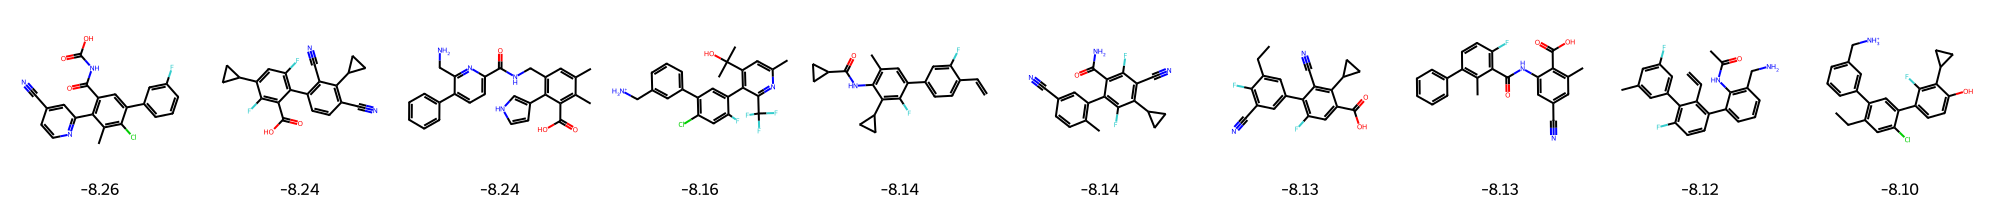

In [808]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(selected_mols, molsPerRow=10, subImgSize=(200, 200), legends=[f'{r["affinities"][i]:.2f}' for i in selected])

In [809]:
ns, nr = evaluate_molecules(selected_mols, pharmacophores)

In [810]:
ns

{'avg_affinity': -8.166302680969238,
 'avg_qed': 0.6675974776869974,
 'avg_sas': 0.7922995828304256,
 'avg_mw': 390.3413000000001,
 'diversity': 0.5359605673652093}

Generate 500. Top 100. Temp 1.0

In [510]:
ns

{'avg_affinity': -8.104858531951905,
 'avg_qed': 0.7483128205886733,
 'avg_sas': 0.7764079849254172,
 'avg_mw': 376.84157000000005,
 'diversity': 0.5366125276301049}

Generate 1000. Top 100. Temp 1.0 (98 seconds)

In [502]:
ns

{'avg_affinity': -8.199220561981202,
 'avg_qed': 0.7070572277534442,
 'avg_sas': 0.7748551925508245,
 'avg_mw': 389.42042000000015,
 'diversity': 0.5425623384827941}

This is the stat to beat: Temp 1.0 - 100

In [494]:
s

{'avg_affinity': -7.67199408531189,
 'avg_qed': 0.7475128673724865,
 'avg_sas': 0.7596037105527509,
 'avg_mw': 380.6106500000002,
 'diversity': 0.6002464280878497}